## Generate synthetic data use the parameters we just calculated

In [1]:
from bond_portfolio_gen import *
from MFM_constructor import *
from utils import seed_all, naive_kernel_estimator
from scipy.stats import ortho_group
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

seed_all(10)
K = 3
m = 11
n_dependence = 4
N = 3000 + n_dependence
real_N = 3000

param_dic = np.load('dataset/synthetic_parameters.npy', allow_pickle=True).item()

A1_ = param_dic["A1_"]
A2_ = param_dic["A2_"]
A3_ = param_dic["A3_"]
A4_ = param_dic["A4_"]
Sigma_xi = param_dic["Sigma_xi"]
Sigma_eps = param_dic["Sigma_eps"]
U = param_dic["U"]
Gamma = param_dic["Gamma"]
eigenVal = param_dic["eigenVals"]


# this positions might be changed manually in an adversarial setting

positions = np.ones(m)/m

S_mature = np.array([1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20, 30])

r_mat = np.zeros((N+1, m))  # interest rate matrix
b_val = np.zeros(N+1)       # bond value matrix
f_prime_mat = np.zeros((N, K))    # F' matrix

r_mat[0] = np.array([5] * m)
b_val[0] = Bond_PortVal(0.01 * r_mat[0], S_mature, positions)


for i in range(N):
    
    if i <= n_dependence-1:
        f = U @ multivariate_normal(np.array([0]*K), np.diag(eigenVal), 1)[0]
    else :
        
        xi = multivariate_normal(np.array([0]*K), Sigma_xi, 1)[0]
        f = A1_ @ f_prime_mat[i-1] + A2_ @ f_prime_mat[i-2] + A3_ @ f_prime_mat[i-3] + A4_ @ f_prime_mat[i-4]+xi
    
    f_prime_mat[i] = f
    
    eps = multivariate_normal(np.array([0]*m), Sigma_eps, 1)[0]
    
    q = np.dot(Gamma, U.T @ f) + eps 
    
    r = np.clip(r_mat[i] + q, a_min = 0, a_max = 100)
    
    r_mat[i+1] = r
    
    b_val[i+1] = Bond_PortVal(0.01 * r_mat[i+1], S_mature, positions)
    
    
r_mat = r_mat[1:]
b_val = b_val[1:]


Z_data, Y_data = MFM_Bond_dataConstruct(
    b_val,
    r_mat,
    f_prime_mat,
    n_dependence
)

Z_data = normalize(Z_data, axis = 0)

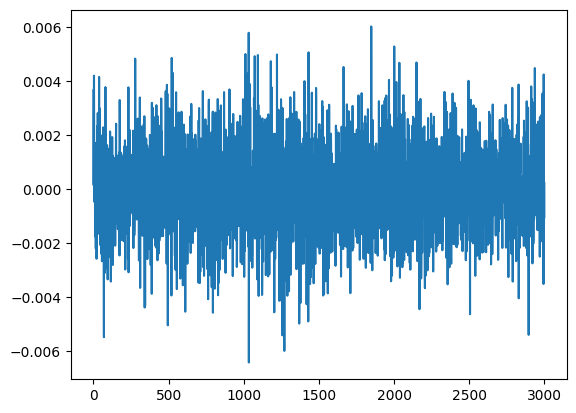

In [2]:
plt.plot(Y_data)

In [3]:
print(U)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [4]:
print(len(Y_data))

3000


## To manually create confidence intervals, we sample multiple Y vals

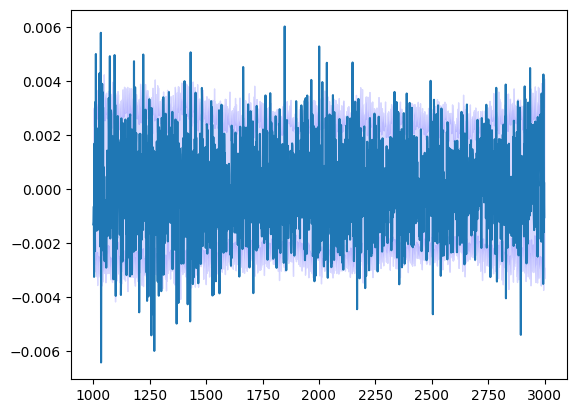

In [5]:
N_sample = 100
quant_interval_alpha = 0.1
steps_beforehead = 2000

sample_holder = np.zeros((N, N_sample))

for j in range(N - steps_beforehead, N):
    
    r_hist = r_mat[j - 1]
    
    samples = np.zeros(N_sample)
    
    for jj in range(N_sample):
        
        new_xi = multivariate_normal(np.array([0]*K), Sigma_xi, 1)[0]
        new_f = A1_ @ f_prime_mat[j-1] + A2_ @ f_prime_mat[j-2] + A3_ @ f_prime_mat[j-3] + A4_ @ f_prime_mat[j-4]+new_xi
        new_eps = multivariate_normal(np.array([0]*m), Sigma_eps, 1)[0]

        new_q = np.dot(Gamma, U.T @ new_f) + new_eps
        
        new_r = np.clip(r_hist + new_q, a_min = 0, a_max = 100)
        new_b = Bond_PortVal(0.01 * new_r, S_mature, positions)
    
        samples[jj] = new_b - b_val[j-1]
    
    
    sample_holder[j] = samples
    

sample_holder = np.sort(sample_holder)
lower = sample_holder[:, int(N_sample * quant_interval_alpha /2)]
upper = sample_holder[:, int(N_sample - N_sample * quant_interval_alpha /2)]

lower = lower[N-steps_beforehead:]
upper = upper[N-steps_beforehead:]


fig, ax = plt.subplots()
x = np.arange(real_N-steps_beforehead,real_N)

ax.plot(x, Y_data[real_N-steps_beforehead:])
ax.fill_between(
    x, lower, upper, color='b', alpha=.15)

In [6]:
Y_effective = Y_data[real_N-steps_beforehead:]

vio = ((Y_effective > upper) | (Y_effective < lower)).astype(int)


vio_poses = np.where(vio > 0)[0]

scalas = [1] * len(vio_poses)

print(len(vio_poses) / len(vio))

0.103


In [7]:
np.mean(upper-lower)

0.00526911601683036

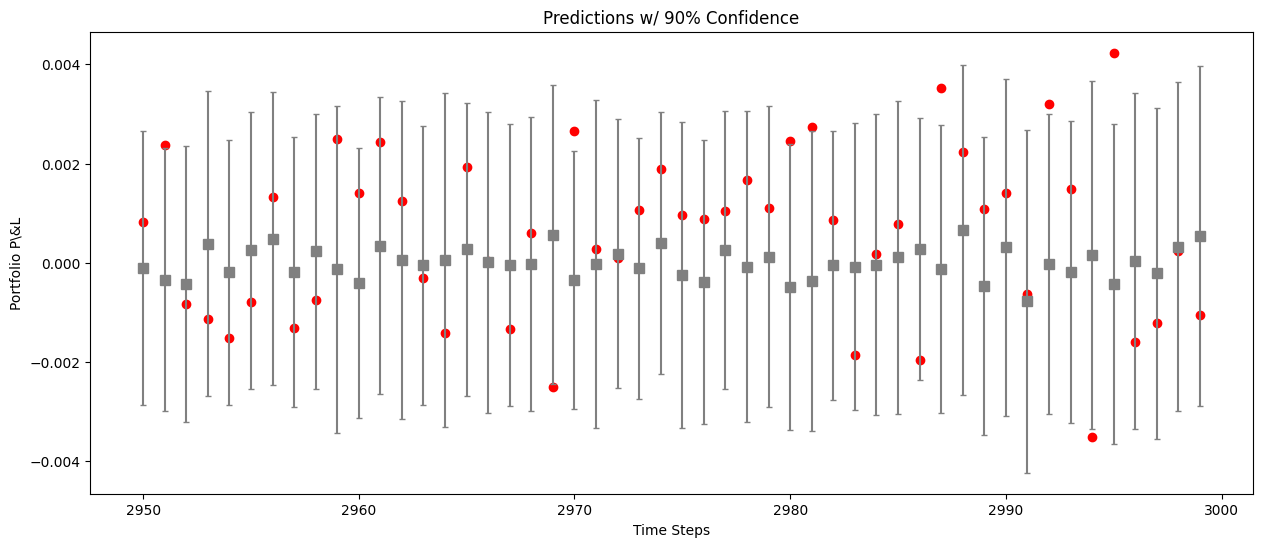

In [45]:

x_index = np.arange(real_N-steps_beforehead,real_N)
fig, ax = plt.subplots(figsize=(15,6))
# ax.plot(x_index, valid['temp'], color='#fc7d0b', label='Valid')

ax.scatter(x_index, Y_effective, color = "red")
# ax.fill_between(x_index, lower, upper, color='b', alpha=.15)


ax.errorbar(x=x_index, y=(upper + lower)/2, yerr=(upper - lower)/2, color="gray", capsize=2, linestyle="None", marker="s", markersize=7, mfc="gray", mec="gray")


ax.set_title("Predictions w/ 90% Confidence")
ax.set_xlabel('Time Steps')
ax.set_ylabel(r'Portfolio P\&L')
plt.show()

## Now we use our kernel estimator to reproduce confidence intervals. We follow a back testing procedure. We start without implementing the first step

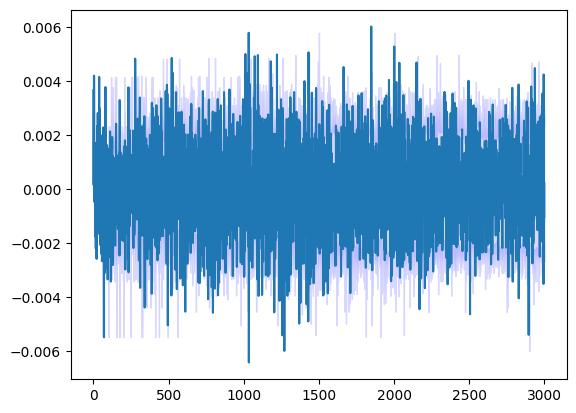

In [84]:
from utils import naive_kernel_estimator, rbf_kernel_estimator

width = 2.5*1E-2

ker_lower = np.zeros(len(Y_data))
ker_upper = np.zeros(len(Y_data))

starting = 100

ker_lower[:starting] = Y_data[:starting]
ker_upper[:starting] = Y_data[:starting]

for i in range(starting, len(Y_data)):
    
    recal_Z = Z_data[:i]
    
    recal_Y = Y_data[:i]
    
    test_Z = Z_data[i:i+1]
    
    quants = rbf_kernel_estimator(
        test_Z,
        recal_Z,
        recal_Y,
        quants = np.array([quant_interval_alpha/2, 1-quant_interval_alpha/2]),
        wid = width,
    )
    
    ker_lower[i] = quants[0, 0]
    ker_upper[i] = quants[1, 0]
    
    
fig, ax = plt.subplots()
x = np.arange(len(Y_data))

ax.plot(x, Y_data)
ax.fill_between(
    x, ker_lower, ker_upper, color='b', alpha=.15)

In [85]:
ker_vio = ((Y_data > ker_upper) | (Y_data < ker_lower)).astype(int)

ker_vio = ker_vio[starting:]

ker_vio_poses = np.where(ker_vio > 0)[0]

scalas = [1] * len(ker_vio_poses)

print(len(ker_vio_poses) / len(ker_vio))

0.13482758620689655


In [86]:
average_intervalLen = np.mean(ker_upper - ker_lower)
average_intervalLen

0.004789175091773204

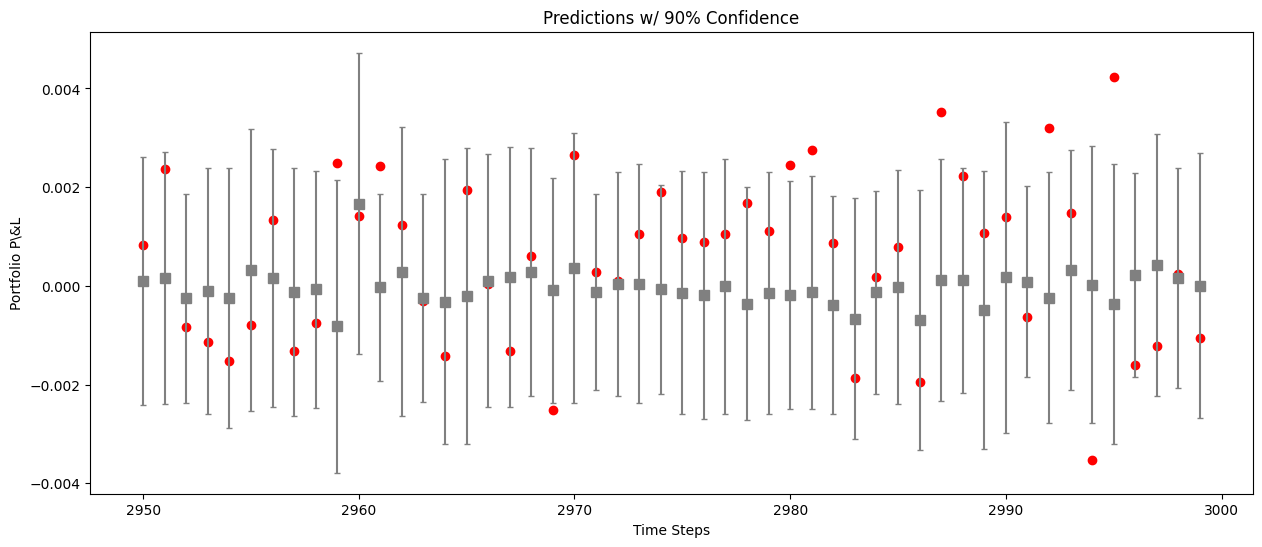

In [87]:
x_index = np.arange(real_N-steps_beforehead,real_N)
fig, ax = plt.subplots(figsize=(15,6))
# ax.plot(x_index, valid['temp'], color='#fc7d0b', label='Valid')

ax.scatter(x_index, Y_effective, color = "red")
# ax.fill_between(x_index, lower, upper, color='b', alpha=.15)


ax.errorbar(x=x_index, y=(ker_upper[-steps_beforehead:] + ker_lower[-steps_beforehead:])/2, yerr=(ker_upper[-steps_beforehead:] - ker_lower[-steps_beforehead:])/2, color="gray", capsize=2, linestyle="None", marker="s", markersize=7, mfc="gray", mec="gray")


ax.set_title("Prediction w/ 90% Confidence")
ax.set_xlabel('Time Steps')
ax.set_ylabel(r'Portfolio P\&L')
plt.show()

## The performance is roughly accpetable. Now the first question we are asking is, whether calibration for scenario analysis will produce smaller  confidence intervals.

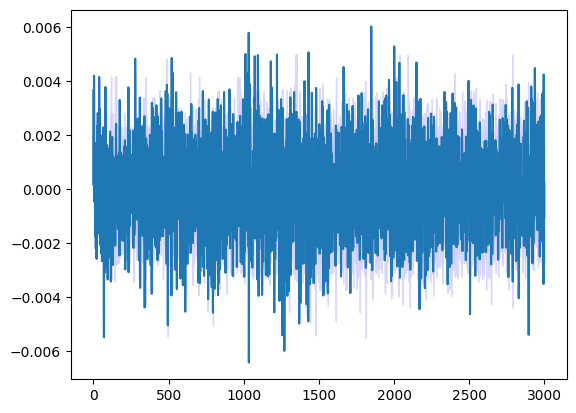

In [88]:
Z_X_data, _ = EMFM_Bond_dataConstruct(
    b_val,
    r_mat,
    f_prime_mat,
    n_dependence,
    A_stress = np.array([
        [1,0,0],
        [0,1,0]
    ])
)

Z_X_data = normalize(Z_X_data, axis = 0)


scenario_kerWidth = 2.5E-2

scenario_ker_lower = np.zeros(len(Y_data))
scenario_ker_upper = np.zeros(len(Y_data))

scenario_ker_lower[:starting] = Y_data[:starting]
scenario_ker_upper[:starting] = Y_data[:starting]

for i in range(starting, len(Y_data)):
    
    scenario_recal_Z = Z_X_data[:i]
    
    scenario_recal_Y = Y_data[:i]
    
    scenario_test_Z = Z_X_data[i:i+1]
    
    scenario_quants = rbf_kernel_estimator(
        scenario_test_Z,
        scenario_recal_Z,
        scenario_recal_Y,
        quants = np.array([quant_interval_alpha/2, 1-quant_interval_alpha/2]),
        wid = scenario_kerWidth,
    )
    
    scenario_ker_lower[i] = scenario_quants[0, 0]
    scenario_ker_upper[i] = scenario_quants[1, 0]
    

fig, ax = plt.subplots()

ax.plot(x, Y_data)
ax.fill_between(
    x, scenario_ker_lower, scenario_ker_upper, color='b', alpha=.15)

In [89]:
scenario_ker_vio = ((Y_data > scenario_ker_upper) | (Y_data < scenario_ker_lower)).astype(int)

scenario_ker_vio = scenario_ker_vio[starting:]

scenario_ker_vio_poses = np.where(scenario_ker_vio > 0)[0]

scenario_scalas = [1] * len(scenario_ker_vio_poses)

print(len(scenario_ker_vio_poses) / len(scenario_ker_vio))

0.07448275862068965


In [90]:
np.mean(scenario_ker_upper - scenario_ker_lower)

0.0033026487608193342

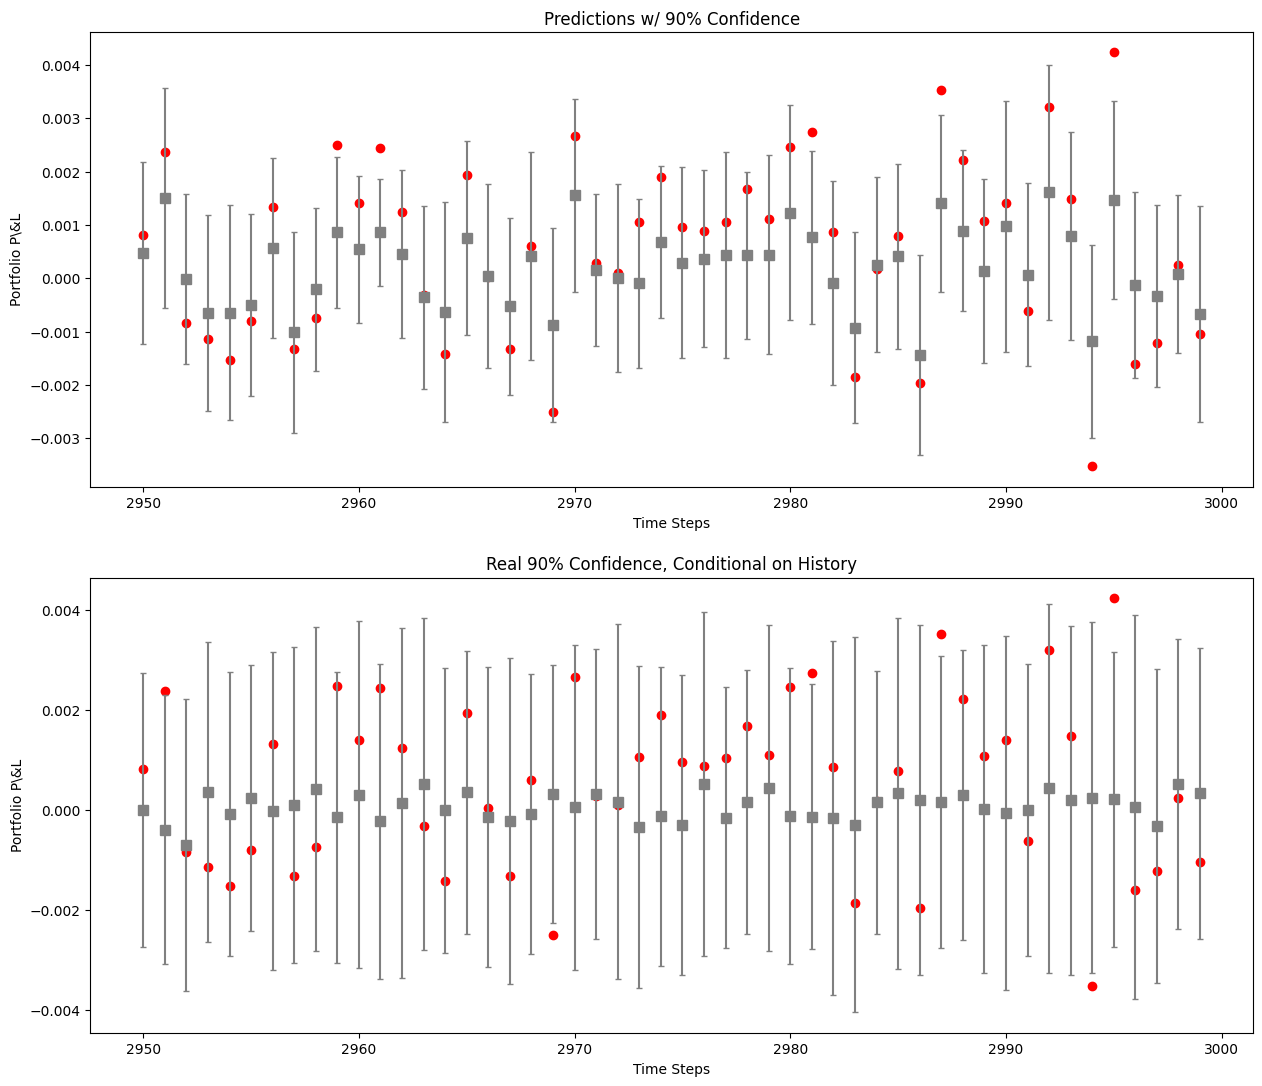

In [95]:
x_index = np.arange(real_N-steps_beforehead,real_N)
fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,13))
# ax.plot(x_index, valid['temp'], color='#fc7d0b', label='Valid')

ax.scatter(x_index, Y_effective, color = "red")
# ax.fill_between(x_index, lower, upper, color='b', alpha=.15)


ax.errorbar(x=x_index, y=(scenario_ker_upper[-steps_beforehead:] + scenario_ker_lower[-steps_beforehead:])/2, yerr=(scenario_ker_upper[-steps_beforehead:] - scenario_ker_lower[-steps_beforehead:])/2, color="gray", capsize=2, linestyle="None", marker="s", markersize=7, mfc="gray", mec="gray")


ax.set_title("Predictions w/ 90% Confidence")
ax.set_xlabel('Time Steps')
ax.set_ylabel(r'Portfolio P\&L')


ax2.scatter(x_index, Y_effective, color = "red")
# ax.fill_between(x_index, lower, upper, color='b', alpha=.15)


ax2.errorbar(x=x_index, y=(upper + lower)/2, yerr=(upper - lower)/2, color="gray", capsize=2, linestyle="None", marker="s", markersize=7, mfc="gray", mec="gray")


ax2.set_title("Real 90% Confidence, Conditional on History")
ax2.set_xlabel('Time Steps')
ax2.set_ylabel(r'Portfolio P\&L')





plt.show()

## The result shows that, scenario calibration can produce much sharper confidence intervals

## A demo of the output of calibration for scenario analysis

## What ordinary scenario analysis will produce

In [28]:
print(np.sqrt(eigenVal))

[0.13421783 0.0780267  0.04439606]


In [33]:
import pandas as pd

sig1, sig2, sig3 = np.sqrt(eigenVal)

pick_index = len(Y_data) - 2
stress_1_list = [-2*sig1, -sig1, 0, sig1, 2*sig1]
stress_2_list = [-2*sig2, -sig2, 0, sig2, 2*sig2]


print("real factors: ", Z_data[pick_index+1][m:m+K])
print("real Y: ", Y_data[pick_index])


mean_mat = np.zeros((len(stress_1_list),len(stress_2_list)))

for i in range(len(stress_1_list)):
    for j in range(len(stress_2_list)):
        stress = np.array([stress_1_list[i],stress_2_list[j]])
        
        assumed_factor = np.concatenate((stress, np.array([0.])))
        
        assumed_rates = np.clip(Z_data[pick_index][:m] +  np.dot(Gamma, U.T @ assumed_factor),  a_min = 0, a_max = 100)
    
        b_val = Bond_PortVal(0.01 * assumed_rates, S_mature, positions)
        
        mean_mat[i,j] = b_val - Bond_PortVal(0.01 * Z_data[pick_index][:m], S_mature, positions)
        

        
d = {"stresses":stress_1_list}
for i in range(len(stress_2_list)):
    d[stress_2_list[i]] = []
    for j in range(len(stress_1_list)):
        d[stress_2_list[i]].append(float(format(mean_mat[j, i], '.2g')))
        

df_vanilla = pd.DataFrame(data=d).set_index("stresses")

df_vanilla           

real factors:  [0.04439781 0.00843892 0.02302482]
real Y:  -0.0034086481912503075


,-0.15605339833036241,-0.07802669916518121,0,0.07802669916518121,0.15605339833036241
stresses,,,,,
-0.268436,0.00082,0.00077,0.00071,0.00066,0.00060
-0.134218,0.00089,0.00084,0.00079,0.00074,0.00066
0.000000,0.00094,0.00076,0.00000,-0.00076,-0.00150
0.134218,-0.00250,-0.00320,-0.00390,-0.00470,-0.00540
0.268436,-0.00650,-0.00720,-0.00790,-0.00860,-0.00930


## Our result

In [34]:


lower_mat = np.zeros((len(stress_1_list),len(stress_2_list)))
upper_mat = np.zeros((len(stress_1_list),len(stress_2_list)))

for i in range(len(stress_1_list)):
    for j in range(len(stress_2_list)):
        stress = np.array([stress_1_list[i],stress_2_list[j]])
        
        factor_s = Z_data[pick_index]
        
        cat = np.concatenate((stress, factor_s)).reshape(1,-1)
        
        
        example_recal_Z = Z_X_data[:pick_index]
    
        example_recal_Y = Y_data[:pick_index]

        example_test_Z = cat

        example_quants = rbf_kernel_estimator(
            example_test_Z,
            example_recal_Z,
            example_recal_Y,
            quants = np.array([quant_interval_alpha/2, 1-quant_interval_alpha/2]),
            wid = scenario_kerWidth,
        )

        lower_mat[i,j] = example_quants[0, 0]
        upper_mat[i,j] = example_quants[1, 0]
        
        
d = {"stresses":stress_1_list}
for i in range(len(stress_2_list)):
    d[stress_2_list[i]] = []
    for j in range(len(stress_1_list)):
        d[stress_2_list[i]].append((float(format(lower_mat[j, i], '.2g')), float(format(upper_mat[j, i], '.2g'))))
        

df = pd.DataFrame(data=d).set_index("stresses")

df    

,-0.15605339833036241,-0.07802669916518121,0,0.07802669916518121,0.15605339833036241
stresses,,,,,
-0.268436,"(0.0037, 0.0037)","(0.0032, 0.0032)","(0.0032, 0.0032)","(0.0032, 0.0032)","(0.0032, 0.0032)"
-0.134218,"(0.0037, 0.0037)","(0.0032, 0.0046)","(0.0032, 0.0032)","(0.0032, 0.0032)","(0.00087, 0.00087)"
0.000000,"(-0.00012, 0.0028)","(-0.00012, 0.0021)","(-0.0011, 0.0018)","(-0.0019, -0.00085)","(-0.0022, -0.0011)"
0.134218,"(-0.00076, -0.00022)","(-0.0027, -0.00076)","(-0.0037, -0.0027)","(-0.0036, -0.0036)","(-0.0036, -0.0036)"
0.268436,"(-0.0037, -0.00022)","(-0.0037, -0.0037)","(-0.0037, -0.0029)","(-0.0037, -0.0029)","(-0.0036, -0.0036)"


## The next example to demonstrate an application of scenario calibration is an adversarial setting. We might simply assume an "approximate" finite step dependence. In this experiment we are deliberately hiding $F_3$, so that only $F_1, F_2$ and $r$ are observable things. We aim to show that, for two portfolios that are both immune to $F_1, F_2$, their scenario calibration performance can potentially vary greatly.

In [1]:
import 

np.square([0.13421783 0.0780267  0.04439606])

SyntaxError: invalid syntax (2642027164.py, line 1)